In [1]:
import SimpleITK as sitk
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2

# https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing

In [2]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

In [3]:
def load_x(path):# load x 3d image
    img, origin, spacing = load_itk(path)
    
    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    #resize image
    resized_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    #print(resized_img.shape)
    normalized_img = ((resized_img - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img))) * 255
    return normalized_img

In [4]:
def load_y(path):# load y 3d image
    img, origin, spacing = load_itk(path)
    img = img / 100# convert label to small interger
    img = img.astype(int)
    #img = np.where( x == label, 1, 0)
    #print(np.max(img))
    
    return img, spacing

def generate_y(img, spacing, z, label):# generate center of a label
    z = int(z / spacing[1])
    y_lst = []
    x_lst = []
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x,z] == label:
                y_lst.append(y)
                x_lst.append(x)
    if not x_lst:
        return False
    x_max, x_min, y_max, y_min = max(x_lst), min(x_lst), max(y_lst), min(y_lst)
    x_center = int(((x_max + x_min) / 2) * y_spacing[1])
    y_center = int((y_max + y_min) / 2)
    
    return (x_center, y_center)

def load_y_label(path, label):
    img, origin, spacing = load_itk(path)
    img = img / 100# convert label to small interger
    img = img.astype(int)
    img = np.where( img == label, 255, 0)
    
    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    #resize image
    resized_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    resized_img = np.where( resized_img > 127, 255, 0)
    
    return resized_img

In [5]:
x = load_x('./Jack/images/case1.mhd')
#y = load_y_label('./Jack/labeled/case1_label.mhd', 19)
#plt.imshow(y[:,:,90], cmap='gray')

In [6]:
#y_img, y_spacing = load_y('./Jack/labeled/case1_label.mhd')
#generate_y(y_img, y_spacing, 90, 19)

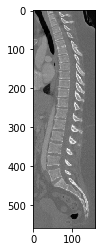

In [7]:
#print(y_img.shape)
#print(y_spacing)
plt.imshow(x[:,:,90], cmap='gray')

In [5]:
def label_center(case, shape):
    yolo_label_path = './boobs-master/ian/bboxes_yolo_multiple_classes/case{}.txt'.format(case)
    with open(yolo_label_path,'r') as f:
        #print(f.readlines())
        lines = f.readlines()
        output = []
        
        for line in lines:
            #line = lines[0]
            line = line.split('\n')[0]
            values = line.split(' ')
            #print(values)
            label = int(values[0])
            center_x = int((float(values[1])) * shape[1])
            center_y = int((float(values[2])) * shape[0])
            output.append({
                'label': label,
                'center': (center_x, center_y)
            })
        #print(output)
        return output
label_center(1, x.shape)
print(x.shape)

NameError: name 'x' is not defined

In [6]:
# generate seg data

for case in range(1, 11):
    #case = 1
    if case == 7:
        continue
    print('# case {}'.format(case))

    z_center_lst = [0, 92, 80, 75, 92, 85, 85, 0, 82, 85, 72] # 0 = none
    z = z_center_lst[case]
    x_path = './Jack/images/case{}.mhd'.format(case)
    y_path = './Jack/labeled/case{}_label.mhd'.format(case)

    x_img = load_x(x_path)
    y_img, y_spacing = load_y(y_path)

    shape = x_img.shape
    
    centers = label_center(case, shape)
    
    for c in centers:
        #label = 19
        label = c['label']
        
        label_shift = [0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1]# fix the ground truth error
        
        print('- label {}'.format(label))
        y_label = load_y_label(y_path, label - label_shift[case])
        
        if np.max(y_label) == 0:
            continue
        
        center = c['center']
        
        center_x, center_y = center
        
        size = 128 # patch size = size*size*size
        min_x, max_x, min_y, max_y = center_x - size/2, center_x + size/2, center_y - size/2, center_y + size/2

        range_x = [
            int(min_x if min_x > 0 else 0),
            int(max_x if max_x < (shape[1] - 1) else (shape[1] - 1))
        ]
        range_y = [
            int(min_y if min_y > 0 else 0),
            int(max_y if max_y < (shape[0] - 1) else (shape[0] - 1))
        ]
        range_z = [
            int(z - size/2),
            int(z + size/2)
        ]
        #print(range_x)
        #print(range_y)
        #print(center_x)

        padding_y = (
        int(size/2) - center_y + range_y[0],
        int(size/2) - range_y[1] + center_y
        )
        padding_x = (
            int(size/2) - center_x + range_x[0],
            int(size/2) - range_x[1] + center_x
        )

        out_x = np.pad(
            x_img[
                range_y[0]: range_y[1]
                , range_x[0]: range_x[1]
                , range_z[0]: range_z[1]],
            (padding_y, padding_x, (0, 0)),
            'constant') / 255
        out_y = np.pad(
            y_label[
                range_y[0]: range_y[1]
                , range_x[0]: range_x[1]
                , range_z[0]: range_z[1]],
            (padding_y, padding_x, (0, 0)),
            'constant') / 255
        #print(np.min(out_x))
        #print(np.max(out_x))
        #print(np.min(out_y))
        #print(np.max(out_y))

        #plt.imshow(out_x[:,:,65], cmap='gray')
        #plt.imshow(out_y[:,:,65], cmap='gray')

        np.save('./seg_data/x/case{}_label{}.npy'.format(case, label), out_x)
        np.save('./seg_data/y/case{}_label{}.npy'.format(case, label), out_y)
        print('case {} label {} done'.format(case, label))

# case 1
- label 1
- label 2
case 1 label 2 done
- label 3
case 1 label 3 done
- label 4
case 1 label 4 done
- label 5
case 1 label 5 done
- label 6
case 1 label 6 done
- label 7
case 1 label 7 done
- label 8
case 1 label 8 done
- label 9
case 1 label 9 done
- label 10
case 1 label 10 done
- label 11
case 1 label 11 done
- label 12
case 1 label 12 done
- label 13
case 1 label 13 done
- label 14
case 1 label 14 done
- label 15
case 1 label 15 done
- label 16
case 1 label 16 done
- label 17
case 1 label 17 done
- label 18
case 1 label 18 done
- label 19
case 1 label 19 done
# case 2
- label 3
case 2 label 3 done
- label 4
case 2 label 4 done
- label 5
case 2 label 5 done
- label 6
case 2 label 6 done
- label 7
case 2 label 7 done
- label 8
case 2 label 8 done
- label 9
case 2 label 9 done
- label 10
case 2 label 10 done
- label 11
case 2 label 11 done
- label 12
case 2 label 12 done
- label 13
case 2 label 13 done
- label 14
case 2 label 14 done
- label 15
case 2 label 15 done
- label 16

1
3
4
5
6
7
8
9
10


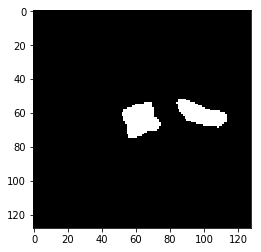

In [50]:
zzz = np.load('./seg_data/y/case{}_label{}.npy'.format(1, 4))
plt.imshow(zzz[:,:,65], cmap='gray')

10
